In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# Pre-Processing

In [3]:
# Tải dữ liệu lên từ file csv
df = pd.read_csv('epl_24-25.csv')

# Xử lý ngày tháng
df['MatchDate'] = pd.to_datetime(df['MatchDate'], dayfirst=False)
df = df.sort_values(by='MatchDate').reset_index(drop=True)

# Tạo cột kết quả: H=1 (Home win), D=0 (Draw), A=2 (Away win)
df['HomeWin'] = (df['FullTimeResult'] == 'H').astype(int)
df['HomeDraw'] = (df['FullTimeResult'] == 'D').astype(int)
df['HomeLoss'] = (df['FullTimeResult'] == 'A').astype(int)
df['AwayWin'] = (df['FullTimeResult'] == 'A').astype(int)
df['AwayDraw'] = (df['FullTimeResult'] == 'D').astype(int)
df['AwayLoss'] = (df['FullTimeResult'] == 'H').astype(int)

# Encode target
label_map = {'H': 1, 'D': 0, 'A': 2}
df['Target'] = df['FullTimeResult'].map(label_map)

In [4]:
# Xử lý Feature

In [5]:
# Tạo df riêng cho home và away
home_df = df[['MatchDate', 'HomeTeam', 'HomeWin', 'HomeDraw',
               'FullTimeHomeGoals', 'FullTimeAwayGoals',
               'HomeShotsOnTarget', 'AwayShotsOnTarget']].copy()
home_df.columns = ['MatchDate', 'Team', 'Win', 'Draw', 'GoalsFor',
                   'GoalsAgainst', 'ShotsFor', 'ShotsAgainst']
home_df['IsHome'] = 1

away_df = df[['MatchDate', 'AwayTeam', 'AwayWin', 'AwayDraw', 'FullTimeAwayGoals',
              'FullTimeHomeGoals', 'AwayShotsOnTarget', 'HomeShotsOnTarget']].copy()
away_df.columns = ['MatchDate', 'Team', 'Win', 'Draw', 'GoalsFor',
                   'GoalsAgainst', 'ShotsFor', 'ShotsAgainst']
away_df['IsHome'] = 0

# Gộp lại
all_matches = pd.concat([home_df, away_df], ignore_index=True)
all_matches = all_matches.sort_values(['MatchDate', 'Team'])

# Hàm tính stats 5 trận gần nhất
def calc_stats(group):
    # Shift để tránh data leak
    shifted = group.sort_values('MatchDate').shift(1)
    rolling = shifted.rolling(window=5, min_periods=1)

    # Tính các chỉ số
    group['WinRate5'] = rolling['Win'].mean()
    group['DrawRate5'] = rolling['Draw'].mean()
    group['AvgGoalsFor5'] = rolling['GoalsFor'].mean()
    group['AvgGoalsAgainst5'] = rolling['GoalsAgainst'].mean()
    group['AvgShotsFor5'] = rolling['ShotsFor'].mean()
    group['AvgShotsAgainst5'] = rolling['ShotsAgainst'].mean()

    # Tỷ lệ thắng sân nhà/khách
    shifted['HomeWin'] = shifted['Win'].where(shifted['IsHome'] == 1)
    shifted['AwayWin'] = shifted['Win'].where(shifted['IsHome'] == 0)

    home_rate = shifted['HomeWin'].rolling(window=5, min_periods=1).mean()
    away_rate = shifted['AwayWin'].rolling(window=5, min_periods=1).mean()

    group['HomeHomeWinRate5'] = np.where(group['IsHome'] == 1, home_rate, np.nan)
    group['AwayAwayWinRate5'] = np.where(group['IsHome'] == 0, away_rate, np.nan)

    return group

# Apply cho từng đội
all_matches = all_matches.groupby('Team', group_keys=False).apply(calc_stats)

# Gộp vào df gốc
stats_cols = ['WinRate5', 'DrawRate5', 'AvgGoalsFor5', 'AvgGoalsAgainst5',
              'AvgShotsFor5', 'AvgShotsAgainst5', 'HomeHomeWinRate5', 'AwayAwayWinRate5']

# Home team stats
home_stats = all_matches[all_matches['IsHome']==1][['MatchDate','Team'] + stats_cols].copy()
home_stats = home_stats.rename(columns={c: 'Home_'+c for c in stats_cols})
df = pd.merge(df, home_stats.rename(columns={'Team':'HomeTeam'}),
              on=['MatchDate','HomeTeam'], how='left')

# Away team stats
away_stats = all_matches[all_matches['IsHome']==0][['MatchDate','Team'] + stats_cols].copy()
away_stats = away_stats.rename(columns={c: 'Away_'+c for c in stats_cols})
df = pd.merge(df, away_stats.rename(columns={'Team':'AwayTeam'}),
              on=['MatchDate','AwayTeam'], how='left')

# Đổi tên cho dễ đọc
df = df.rename(columns={
    'Home_WinRate5': 'HomeWinRate5',
    'Away_WinRate5': 'AwayWinRate5',
    'Home_DrawRate5': 'HomeDrawRate5',
    'Away_DrawRate5': 'AwayDrawRate5',
    'Home_AvgGoalsFor5': 'HomeAvgGoals5',
    'Away_AvgGoalsFor5': 'AwayAvgGoals5',
    'Home_AvgGoalsAgainst5': 'HomeAvgGoalsConceded5',
    'Away_AvgGoalsAgainst5': 'AwayAvgGoalsConceded5',
    'Home_AvgShotsFor5': 'HomeAvgShotOnTarget5',
    'Away_AvgShotsFor5': 'AwayAvgShotOnTarget5',
    'Home_AvgShotsAgainst5': 'HomeAvgShotsConceded5',
    'Away_AvgShotsAgainst5': 'AwayAvgShotsConceded5',
    'Home_HomeHomeWinRate5': 'HomeHomeWinRate5',
    'Away_AwayAwayWinRate5': 'AwayAwayWinRate5'
})

# H2H feature
df['Head2Head_HomeWinRate5'] = np.nan
df['Head2Head_DrawRate5'] = np.nan
df['Head2Head_AwayWinRate5'] = np.nan

for idx, row in df.iterrows():
    h_team = row['HomeTeam']
    a_team = row['AwayTeam']
    date = row['MatchDate']

    # Lấy 5 trận đối đầu gần nhất
    h2h = df[
        (((df['HomeTeam']==h_team) & (df['AwayTeam']==a_team)) |
         ((df['HomeTeam']==a_team) & (df['AwayTeam']==h_team))) &
        (df['MatchDate'] < date)
    ].sort_values('MatchDate', ascending=False).head(5)

    if len(h2h) == 0:
        continue

    h_wins = d_draws = a_wins = 0
    for _, match in h2h.iterrows():
        if match['FullTimeResult'] == 'D':
            d_draws += 1
        elif (match['HomeTeam']==h_team and match['FullTimeResult']=='H') or \
             (match['AwayTeam']==h_team and match['FullTimeResult']=='A'):
            h_wins += 1
        else:
            a_wins += 1

    total = len(h2h)
    df.loc[idx, 'Head2Head_HomeWinRate5'] = h_wins / total
    df.loc[idx, 'Head2Head_DrawRate5'] = d_draws / total
    df.loc[idx, 'Head2Head_AwayWinRate5'] = a_wins / total

# Chuẩn bị data
feature_cols = [
    'HomeWinRate5', 'AwayWinRate5',
    'HomeDrawRate5', 'AwayDrawRate5',
    'HomeAvgGoals5', 'AwayAvgGoals5',
    'HomeAvgGoalsConceded5', 'AwayAvgGoalsConceded5',
    'HomeHomeWinRate5', 'AwayAwayWinRate5',
    'HomeAvgShotOnTarget5', 'AwayAvgShotOnTarget5',
    'HomeAvgShotsConceded5', 'AwayAvgShotsConceded5',
    'Head2Head_HomeWinRate5', 'Head2Head_DrawRate5', 'Head2Head_AwayWinRate5'
]

X = df[feature_cols].copy()
y = df['Target'].copy()

# Điền NaN bằng giá trị trung bình giải đấu tránh misleak data
avg_goals = df[['FullTimeHomeGoals', 'FullTimeAwayGoals']].mean().mean()
avg_shots = df[['HomeShotsOnTarget', 'AwayShotsOnTarget']].mean().mean()

fill_values = {
    'HomeWinRate5': 0.33, 'AwayWinRate5': 0.33,
    'HomeDrawRate5': 0.27, 'AwayDrawRate5': 0.27,
    'HomeAvgGoals5': avg_goals, 'AwayAvgGoals5': avg_goals,
    'HomeAvgGoalsConceded5': avg_goals, 'AwayAvgGoalsConceded5': avg_goals,
    'HomeHomeWinRate5': 0.33, 'AwayAwayWinRate5': 0.33,
    'HomeAvgShotOnTarget5': avg_shots, 'AwayAvgShotOnTarget5': avg_shots,
    'HomeAvgShotsConceded5': avg_shots, 'AwayAvgShotsConceded5': avg_shots,
    'Head2Head_HomeWinRate5': 0.33,
    'Head2Head_DrawRate5': 0.27,
    'Head2Head_AwayWinRate5': 0.33
}
X = X.fillna(fill_values)
# Train-test split 80 huấn luyện và 20 test
split_point = int(len(X) * 0.8)
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

# Chuẩn hóa
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Grid Search
param_grid = {
    'n_neighbors': list(range(1, 62, 2)),
    'weights': ['distance'],
    'metric': ['manhattan', 'euclidean', 'chebyshev']
}

# Dùng 3-fold
tscv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=tscv,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)
best_k = grid.best_params_['n_neighbors']
best_metric = grid.best_params_['metric']
best_score = grid.best_score_

print(f"\nKết quả tốt nhất:")
print(f"- K = {best_k}")
print(f"- Metric = {best_metric}")
print(f"- CV Accuracy = {best_score:.4f}")


Kết quả tốt nhất:
- K = 19
- Metric = chebyshev
- CV Accuracy = 0.5046


In [6]:
# Biểu đồ thực nghiệm

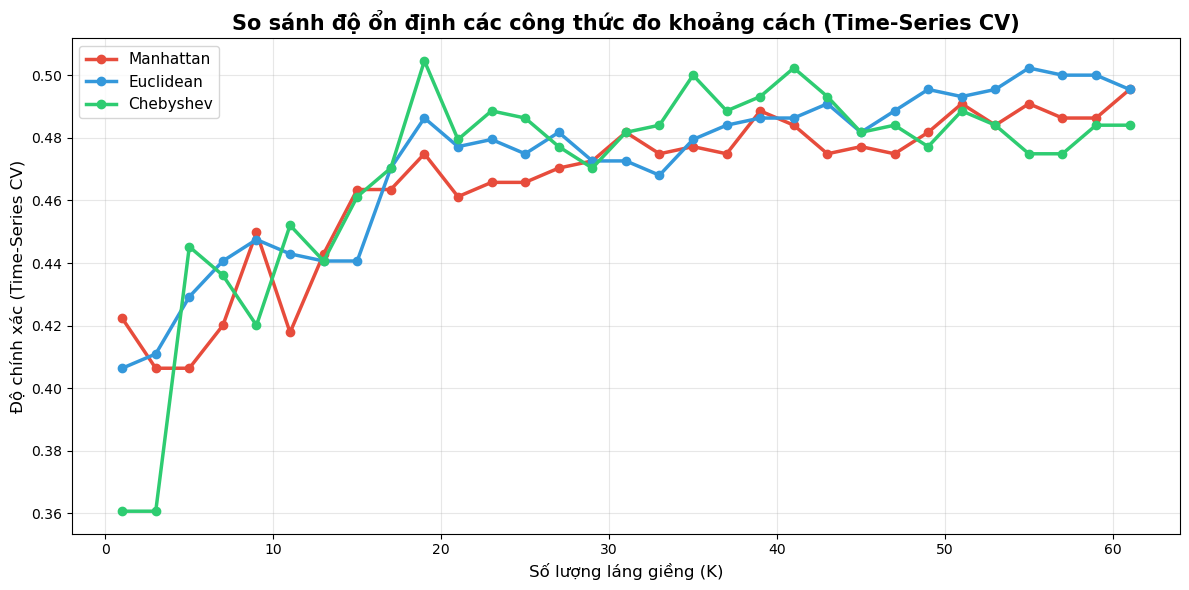

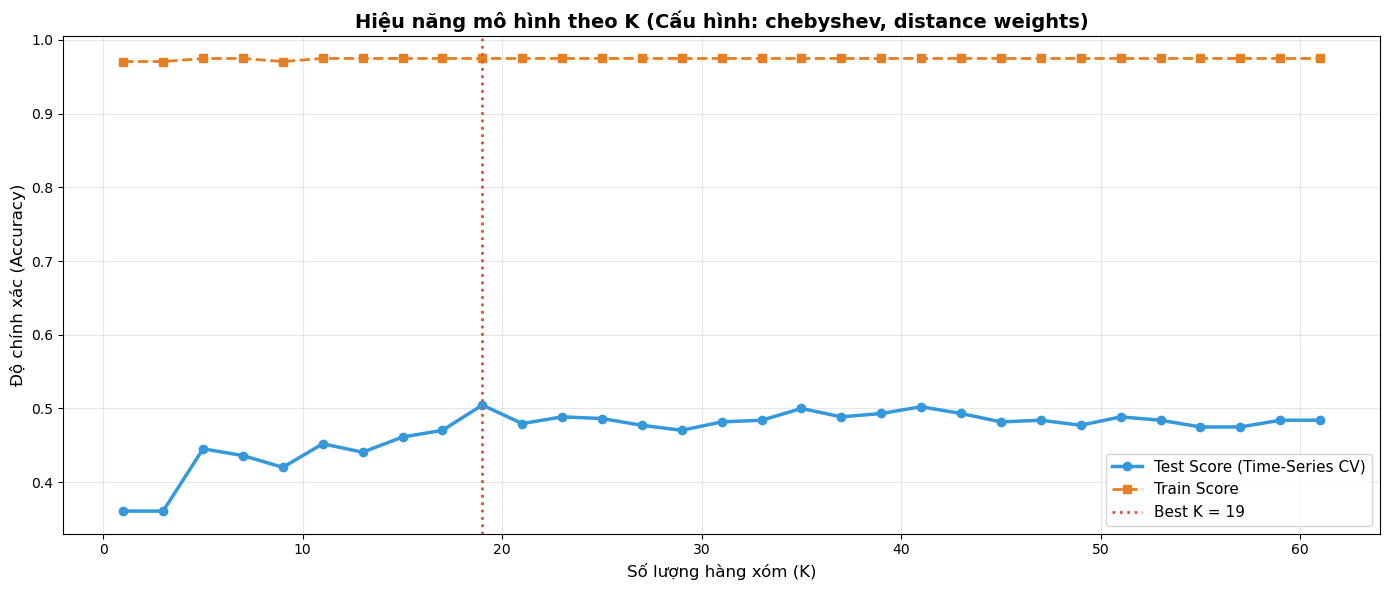

Accuracy trên test set: 0.5068 (50.68%)

Classification Report:
              precision    recall  f1-score   support

    Draw (0)       0.39      0.24      0.30        29
 HomeWin (1)       0.54      0.75      0.63        64
 AwayWin (2)       0.49      0.36      0.41        53

    accuracy                           0.51       146
   macro avg       0.47      0.45      0.45       146
weighted avg       0.49      0.51      0.48       146



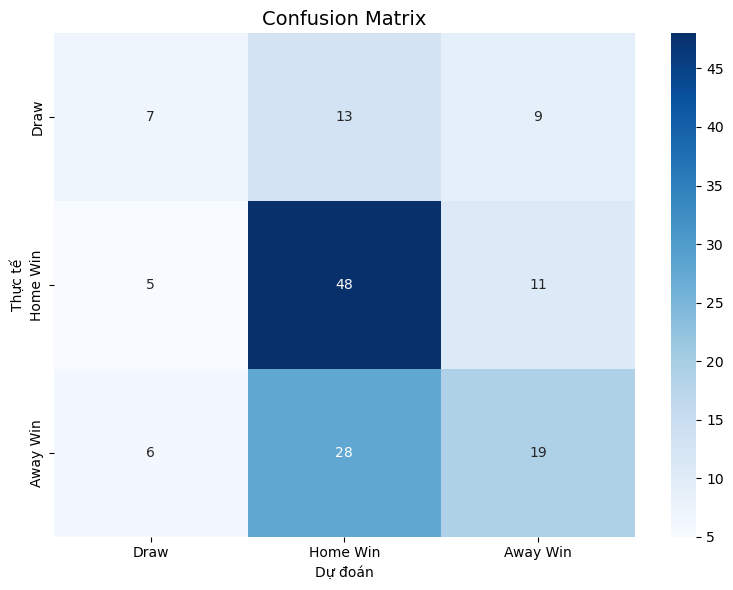

In [7]:
results = pd.DataFrame(grid.cv_results_)

# Biểu đồ 1: So sánh 3 metrics
plt.figure(figsize=(12, 6))
colors = {'manhattan': '#e74c3c', 'euclidean': '#3498db', 'chebyshev': '#2ecc71'}
for metric in ['manhattan', 'euclidean', 'chebyshev']:
    mask = results['param_metric'] == metric
    data = results[mask]
    plt.plot(data['param_n_neighbors'], data['mean_test_score'],
             marker='o', label=metric.capitalize(),
             color=colors[metric], linewidth=2.5)

plt.xlabel('Số lượng láng giềng (K)', fontsize=12)
plt.ylabel('Độ chính xác (Time-Series CV)', fontsize=12)
plt.title('So sánh độ ổn định các công thức đo khoảng cách (Time-Series CV)',
          fontsize=15, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Biểu đồ 2: Phân tích Train vs Test cho best metric
best_data = results[results['param_metric'] == best_metric]

plt.figure(figsize=(14, 6))
# Đường Test Score (xanh dương)
plt.plot(best_data['param_n_neighbors'], best_data['mean_test_score'],
         marker='o', label='Test Score (Time-Series CV)',
         color='#3498db', linewidth=2.5)
# Đường Train Score (cam)
plt.plot(best_data['param_n_neighbors'], best_data['mean_train_score'],
         marker='s', linestyle='--', label='Train Score',
         color='#e67e22', linewidth=2)
# Đánh dấu K tối ưu
plt.axvline(x=best_k, color='#e74c3c', linestyle=':',
            label=f'Best K = {best_k}', linewidth=2)

plt.xlabel('Số lượng hàng xóm (K)', fontsize=12)
plt.ylabel('Độ chính xác (Accuracy)', fontsize=12)
plt.title(f'Hiệu năng mô hình theo K (Cấu hình: {best_metric}, distance weights)',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Đánh giá trên test set
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_pred)

print(f"Accuracy trên test set: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred,
                          target_names=['Draw (0)', 'HomeWin (1)', 'AwayWin (2)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Draw', 'Home Win', 'Away Win'],
            yticklabels=['Draw', 'Home Win', 'Away Win'])
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

In [8]:
# Demo sau huấn luyện

In [9]:
# Lấy 20 trận đầu tiên trong tập Test để chạy thử
demo_indices = list(range(split_point, min(split_point + 20, len(df))))
demo_df = df.iloc[demo_indices].copy()

# Tạo bảng kết quả demo
print(f"\n--- Bảng dự đoán 20 trận đầu tiên trong tập Test (minh họa) ---\n")

results_table = []
for idx, row in demo_df.iterrows():
    # Lấy features của trận đấu
    X_match = X.loc[idx:idx]
    X_match_scaled = scaler.transform(X_match)
    
# Dự đoán
    prediction = best_model.predict(X_match_scaled)[0]
    actual = y.loc[idx]
    
# Map về tên
    result_map = {0: 'Draw', 1: 'Home Win', 2: 'Away Win'}
    pred_label = result_map[prediction]
    actual_label = result_map[actual]
    
# Kiểm tra đúng sai
    correct = "True" if prediction == actual else "False"
    results_table.append({
        'STT': len(results_table),
        'Trận đấu': f"{row['HomeTeam']} vs {row['AwayTeam']}",
        'Thực tế': actual_label,
        'Dự đoán': pred_label,
        'Kết quả': correct
    })

# In bảng
results_df = pd.DataFrame(results_table)
print(results_df.to_string(index=False))

# Thống kê trên các tập test (146 trận)
print("Thông kê trên các tập test")

all_test_results = []
for idx in range(split_point, len(df)):
    X_match = X.loc[idx:idx]
    X_match_scaled = scaler.transform(X_match)
    
    prediction = best_model.predict(X_match_scaled)[0]
    actual = y.loc[idx]
    
    all_test_results.append(prediction == actual)

total_test = len(all_test_results)
correct_test = sum(all_test_results)
full_accuracy = correct_test / total_test

print(f"Tổng số trận test: {total_test} trận")
print(f"Số dự đoán đúng: {correct_test} trận")
print(f"Độ chính xác trên toàn bộ test set: {full_accuracy:.4f} ({full_accuracy*100:.2f}%)")
print(f"{'─'*80}")


--- Bảng dự đoán 20 trận đầu tiên trong tập Test (minh họa) ---

 STT                     Trận đấu  Thực tế  Dự đoán Kết quả
   0  Leicester vs Crystal Palace Away Win     Draw   False
   1          Newcastle vs Wolves Home Win Home Win    True
   2         Arsenal vs Tottenham Home Win Home Win    True
   3          Ipswich vs Brighton Away Win Home Win   False
   4    Man United vs Southampton Home Win Home Win    True
   5       Arsenal vs Aston Villa     Draw Home Win   False
   6   West Ham vs Crystal Palace Away Win Away Win    True
   7       Brentford vs Liverpool Away Win Away Win    True
   8     Newcastle vs Bournemouth Away Win Home Win   False
   9          Leicester vs Fulham Away Win Away Win    True
  10         Everton vs Tottenham Home Win Away Win   False
  11       Man United vs Brighton Away Win Home Win   False
  12 Nott'm Forest vs Southampton Home Win Home Win    True
  13          Ipswich vs Man City Away Win Home Win   False
  14            Chelsea vs Wolves 

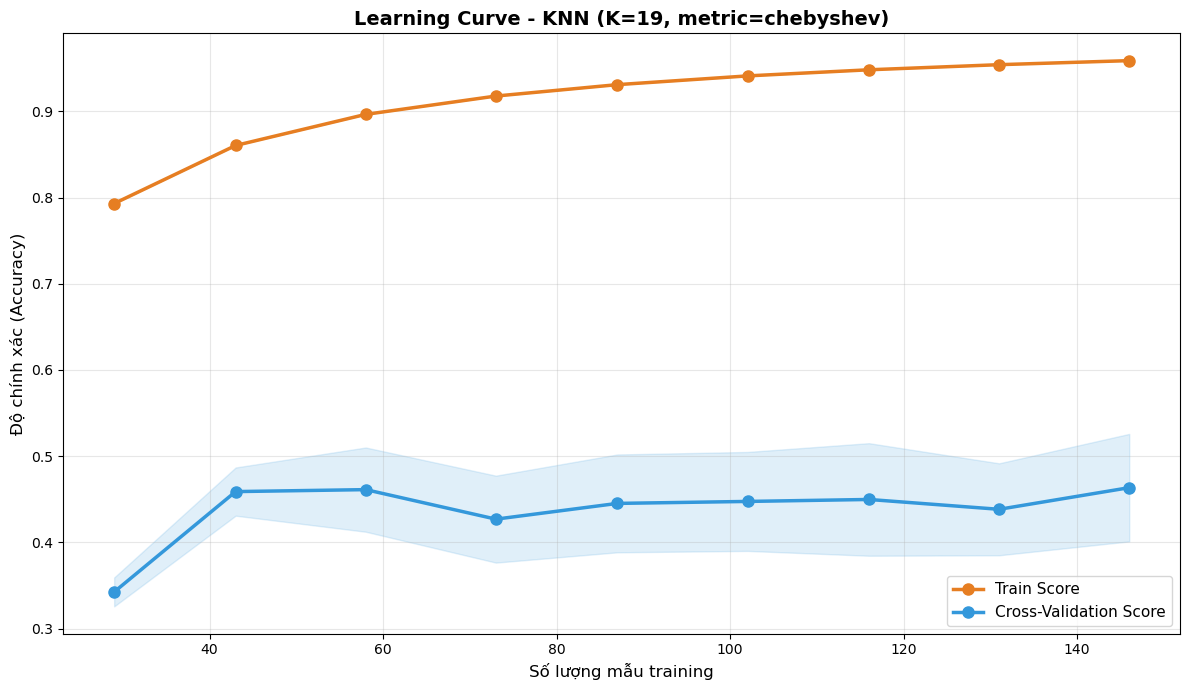

Phân tích Learning Curve
Train score cuối: 0.9589 (±0.0000)
CV score cuối: 0.4635 (±0.0624)
Gap (Overfitting): 0.4954
Mô hình có dấu hiệu OVERFITTING (train >> test)


In [10]:
from sklearn.model_selection import learning_curve

# Tạo learning curve với mô hình tốt nhất
train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X_train_scaled, 
    y_train,
    cv=tscv,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

# Tính mean và std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Biểu đồ
plt.figure(figsize=(12, 7))

# Vùng uncertainty (độ lệch chuẩn)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                 alpha=0.15, color='#e67e22')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, 
                 alpha=0.15, color='#3498db')

# Đường chính
plt.plot(train_sizes, train_mean, 'o-', color='#e67e22', linewidth=2.5, 
         markersize=8, label='Train Score')
plt.plot(train_sizes, test_mean, 'o-', color='#3498db', linewidth=2.5, 
         markersize=8, label='Cross-Validation Score')

plt.xlabel('Số lượng mẫu training', fontsize=12)
plt.ylabel('Độ chính xác (Accuracy)', fontsize=12)
plt.title(f'Learning Curve - KNN (K={best_k}, metric={best_metric})', 
          fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Phân tích Learning Curve")
print(f"Train score cuối: {train_mean[-1]:.4f} (±{train_std[-1]:.4f})")
print(f"CV score cuối: {test_mean[-1]:.4f} (±{test_std[-1]:.4f})")
print(f"Gap (Overfitting): {train_mean[-1] - test_mean[-1]:.4f}")

if train_mean[-1] - test_mean[-1] > 0.1:
    print("Mô hình có dấu hiệu OVERFITTING (train >> test)")
elif test_mean[-1] < 0.4:
    print("Mô hình có dấu hiệu UNDERFITTING (cả 2 đều thấp)")
else:
    print("Mô hình có độ cân bằng tốt")